## Group Cross-Validation

In this notebook we will demonstrate how to use 2 schemes of group cross-validation to first estimate the estimator generalization error, and then select the best hyperparameters.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import (
    GroupKFold,
    LeaveOneGroupOut,
    cross_validate,
    GridSearchCV,
)

In [2]:
# load dataset
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

# add patients arbitrarily for the demo
patient_list = [p for p in range(10)]

np.random.seed(1)
X["patient"] = np.random.choice(patient_list, size=len(X))

X.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,patient
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,5
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,8
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,9
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,5
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
# number of patients
X["patient"].nunique()

10

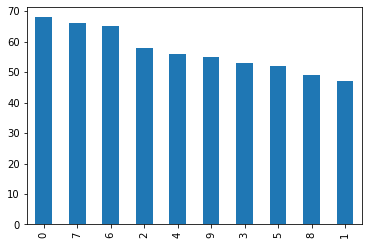

In [4]:
# observations per patient

X["patient"].value_counts().plot.bar()
plt.show()

In [5]:
# split dataset into a train and test set
# this time, we leave data from 1 patient out

# all patients except 7
X_train = X[X['patient']!=7]
y_train = y.iloc[X_train.index]

# patient 7
X_test = X[X['patient']==7]
y_test = y.iloc[X_test.index]

# the test set will not be used in the cross-validation!

## Group K-Fold Cross-Validation

In [6]:
# Logistic Regression
logit = LogisticRegression(
    penalty ='l2', C=10, solver='liblinear', random_state=4, max_iter=10000)

# Group K-Fold Cross-Validation
gkf = GroupKFold(n_splits=5)

# estimate generalization error
clf =  cross_validate(
    logit,
    X_train.drop('patient', axis=1), # drop the patient column, this is not a predictor
    y_train,
    scoring='accuracy',
    return_train_score=True,
    cv=gkf.split(X_train.drop('patient', axis=1), y_train, groups=X_train['patient']),
)

clf['test_score']

array([0.94117647, 0.98214286, 0.94392523, 0.94444444, 0.96296296])

In [7]:
clf['train_score']

array([0.97011494, 0.96419437, 0.97727273, 0.96708861, 0.97721519])

In [8]:
print('mean train set accuracy: ', np.mean(clf['train_score']), ' +- ', np.std(clf['train_score']))
print('mean test set accuracy: ', np.mean(clf['test_score']), ' +- ', np.std(clf['test_score']))

mean train set accuracy:  0.9711771681342704  +-  0.005295613666671954
mean test set accuracy:  0.954930393756672  +-  0.01565426086525203


In [9]:
# # fit the model to entire train set
logit.fit(
    X_train.drop('patient', axis=1), # drop the patient column, this is not a predictor
    y_train)

# let's get the predictions
train_preds = logit.predict(X_train.drop('patient', axis=1))
test_preds = logit.predict(X_test.drop('patient', axis=1))

print('Train Accuracy: ', accuracy_score(y_train, train_preds))
print('Test Accuracy: ', accuracy_score(y_test, test_preds))

Train Accuracy:  0.9721669980119284
Test Accuracy:  0.9545454545454546


## Leave One Group Out

In [11]:
# Logistic Regression
logit = LogisticRegression(
    penalty ='l2', C=10, solver='liblinear', random_state=4, max_iter=10000)

# Cross-Validation
logo = LeaveOneGroupOut()

# estimate generalization error
clf =  cross_validate(
    logit,
    X_train.drop('patient', axis=1), # drop the patient column, this is not a predictor
    y_train,
    scoring='accuracy',
    return_train_score=True,
    cv=logo.split(X_train.drop('patient', axis=1), y_train, groups=X_train['patient']),
)

clf['test_score']

array([0.94117647, 0.9787234 , 0.9137931 , 0.94339623, 0.92857143,
       0.98076923, 0.98461538, 0.97959184, 0.98181818])

In [12]:
print('mean train set accuracy: ', np.mean(clf['train_score']), ' +- ', np.std(clf['train_score']))
print('mean test set accuracy: ', np.mean(clf['test_score']), ' +- ', np.std(clf['test_score']))

mean train set accuracy:  0.9704258511609576  +-  0.0041564759661007825
mean test set accuracy:  0.9591616963573161  +-  0.025807482267073915


## Hyperparameter tuning with Leave 1 Group Out

In [13]:
# Logistic Regression
logit = LogisticRegression(
    penalty ='l2', C=1, solver='liblinear', random_state=4, max_iter=10000)

# hyperparameter space
param_grid = dict(
    penalty=['l1', 'l2'],
    C=[0.1, 1, 10],
)

# Cross-Validation
logo = LeaveOneGroupOut()

# search
clf = GridSearchCV(
    logit,
    param_grid,
    scoring='accuracy',
    cv=logo.split(X_train.drop('patient', axis=1), y_train, groups=X_train['patient']),
    refit=True, # refits best model to entire dataset
)

search = clf.fit(
    X_train.drop('patient', axis=1), # drop the patient column, this is not a predictor
    y_train,
)

# best hyperparameters
search.best_params_

{'C': 10, 'penalty': 'l1'}

In [14]:
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
results

,params,mean_test_score,std_test_score
0,"{'C': 0.1, 'penalty': 'l1'}",0.926777,0.032700
1,"{'C': 0.1, 'penalty': 'l2'}",0.936519,0.029256
2,"{'C': 1, 'penalty': 'l1'}",0.954721,0.020197
3,"{'C': 1, 'penalty': 'l2'}",0.948504,0.023165
4,"{'C': 10, 'penalty': 'l1'}",0.966936,0.024317
5,"{'C': 10, 'penalty': 'l2'}",0.959162,0.025807


Text(0.5, 0, 'Hyperparameter space')

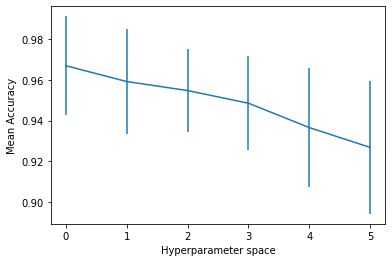

In [15]:
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean Accuracy')

plt.xlabel('Hyperparameter space')

In [16]:
# let's get the predictions
train_preds = search.predict(X_train.drop('patient', axis=1))
test_preds = search.predict(X_test.drop('patient', axis=1))

print('Train Accuracy: ', accuracy_score(y_train, train_preds))
print('Test Accuracy: ', accuracy_score(y_test, test_preds))

Train Accuracy:  0.9860834990059643
Test Accuracy:  0.9545454545454546
